In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import nibabel as nib

from scipy import ndimage


In [3]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

In [4]:
def resize_volume(img):
    desired_depth = 121
    desired_width = 121
    desired_height = 145
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    img = ndimage.rotate(img, 90, reshape=False)
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [5]:
def process_scan(path):
    volume = read_nifti_file(path)
    
    volume = resize_volume(volume)
    return volume

In [6]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/PPMI/Control_Male/GM", x)
    for x in os.listdir("/content/drive/MyDrive/PPMI/Control_Male/GM")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/PPMI/PD_Male/GM", x)
    for x in os.listdir("/content/drive/MyDrive/PPMI/PD_Male/GM")
]

print("Gray matter in MRI scans with healthy control: " + str(len(normal_scan_paths)))
print("Gray matter in MRI scans with parkinson disease: " + str(len(abnormal_scan_paths)))


Gray matter in MRI scans with healthy control: 94
Gray matter in MRI scans with parkinson disease: 100


In [7]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


In [8]:
print(abnormal_scans.shape)
print(normal_scans.shape)

(100, 121, 145, 121)
(94, 121, 145, 121)


In [9]:
x_train = np.concatenate((abnormal_scans[:60], normal_scans[:57]), axis=0).astype("float32");
y_train = np.concatenate((abnormal_labels[:60], normal_labels[:57]), axis=0)
x_val = np.concatenate((abnormal_scans[60:80], normal_scans[57:76]), axis=0).astype("float32");
y_val = np.concatenate((abnormal_labels[60:80], normal_labels[57:76]), axis=0)
x_test = np.concatenate((abnormal_scans[80:], normal_scans[76:]), axis=0).astype("float32");
y_test = np.concatenate((abnormal_labels[80:], normal_labels[76:]), axis=0)
print(
    "Number of samples in train and validation and test are %d and %d and %d."
    % (x_train.shape[0], x_val.shape[0],x_test.shape[0])
)

Number of samples in train and validation and test are 117 and 39 and 38.


In [10]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):

    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def test_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [11]:
# data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (121, 145, 121, 1)


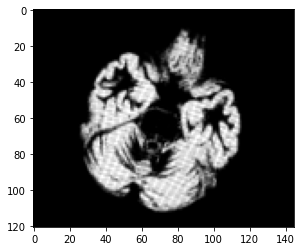

In [12]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

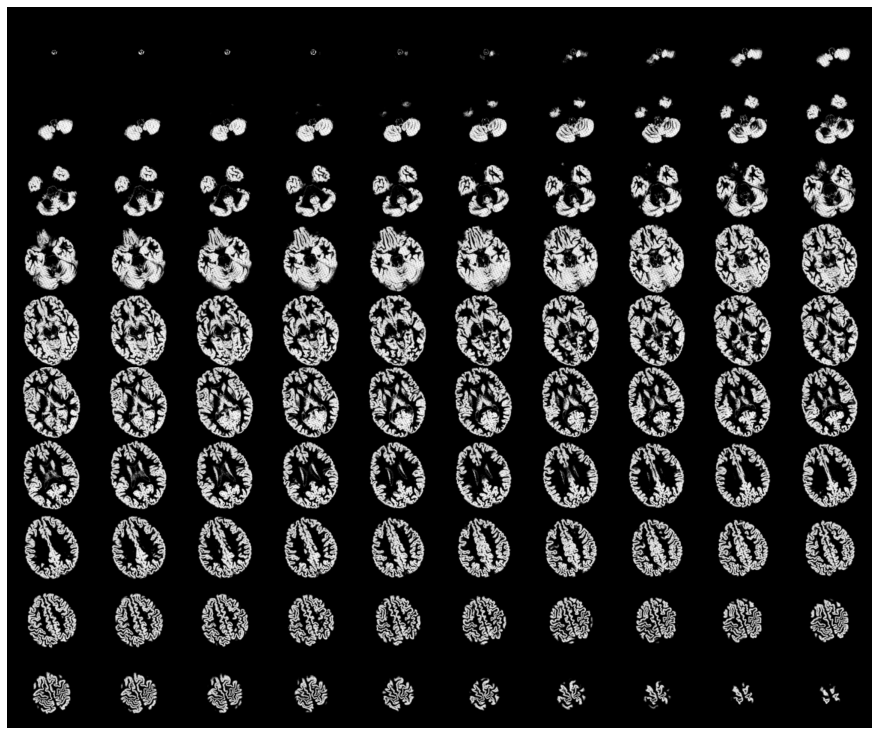

In [13]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

plot_slices(10, 10, 121, 145, image[:, :, :100])

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 121, 145, 121, 1) 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 119, 143, 119, 64) 1792      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 59, 71, 59, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 59, 71, 59, 64)    256       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 57, 69, 57, 64)    110656    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 28, 34, 28, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 34, 28, 64)    256   

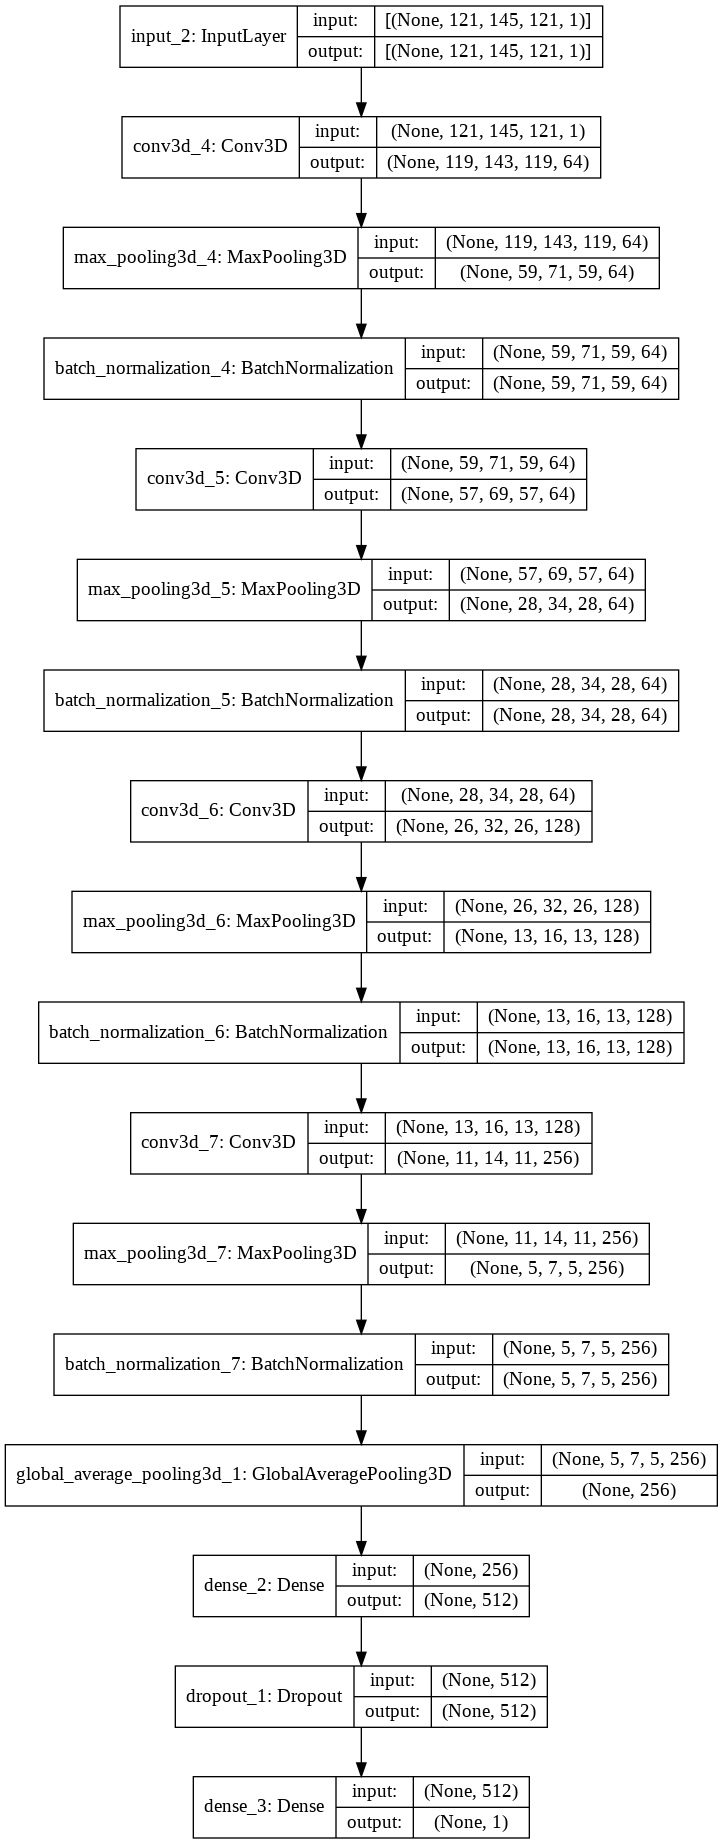

In [15]:
from keras.utils import plot_model

def get_model(width=121, height=145, depth=121):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.6)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=121, height=145, depth=121)
model.summary()
plot_model(model, to_file='/content/drive/MyDrive/model.png', show_shapes=True)

In [16]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/GM_men.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
59/59 - 74s - loss: 0.6851 - acc: 0.5385 - val_loss: 1.2761 - val_acc: 0.4872
Epoch 2/100
59/59 - 44s - loss: 0.6930 - acc: 0.4957 - val_loss: 1.7592 - val_acc: 0.4872
Epoch 3/100
59/59 - 44s - loss: 0.6936 - acc: 0.5470 - val_loss: 2.2354 - val_acc: 0.4872
Epoch 4/100
59/59 - 44s - loss: 0.6900 - acc: 0.4957 - val_loss: 2.6364 - val_acc: 0.4872
Epoch 5/100
59/59 - 44s - loss: 0.6667 - acc: 0.6068 - val_loss: 1.7675 - val_acc: 0.4872
Epoch 6/100
59/59 - 44s - loss: 0.6687 - acc: 0.6325 - val_loss: 2.7995 - val_acc: 0.4872
Epoch 7/100
59/59 - 44s - loss: 0.6590 - acc: 0.6496 - val_loss: 3.7896 - val_acc: 0.4872
Epoch 8/100
59/59 - 43s - loss: 0.6743 - acc: 0.6068 - val_loss: 2.8371 - val_acc: 0.4872
Epoch 9/100
59/59 - 43s - loss: 0.6206 - acc: 0.6923 - val_loss: 3.5584 - val_acc: 0.4872
Epoch 10/100
59/59 - 44s - loss: 0.6173 - acc: 0.6581 - val_loss: 2.5124 - val_acc: 0.4872
Epoch 11/100
59/59 - 44s - loss: 0.6591 - acc: 0.5385 - val_loss: 1.9786 - val_acc: 0.4872
Epoch 12

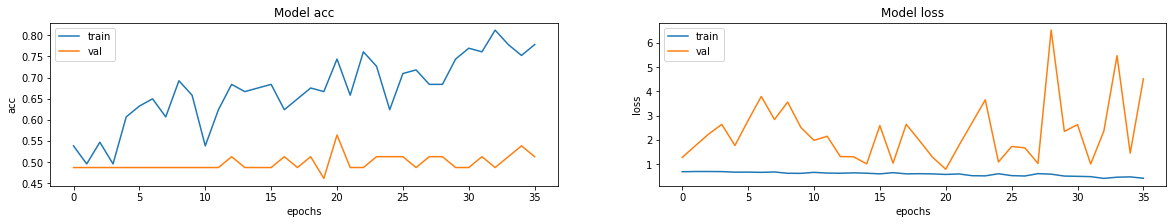

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [18]:
result = model.evaluate(test_dataset)


19/19 [==============================] - 2s 63ms/step - loss: 3.3427 - acc: 0.5263


In [19]:
print(result)

[3.342724561691284, 0.5263158082962036]
